# Packages

In [1]:
import os
from tqdm import tqdm
import pickle
import random
from typing import List, Dict, Tuple
from anndata import AnnData
import scanpy as sc
import time
import itertools

import pandas as pd
import numpy as np
import math
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns
import statsmodels
import umap

from molmass import Formula
import metaspace
import linex2metaspace as lx2m
import linex2 as lx2
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy import stats
import networkx as nx
from collections import defaultdict

from metaspace import SMInstance
from metaspace_converter import metaspace_to_anndata
import squidpy as sq

/home/trose/.conda/envs/metabolomics2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/trose/.conda/envs/metabolomics2/lib/python3.10/site-packages/linex2/parser.py:22: RuntimeWarning: Package 'lynx' (LipidLynxX) not available. Lipid name conversions will not be possible.
  warnings.warn(


In [58]:
import utils
from coloc_utils import *
from config import store_dir, data_dir, date_key, enrichment_dir, module_dir, figuredata_dir
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# ###################################################
# Code to use if colocalizations are not pre-computed
# ###################################################

# pos_lip_top_datasets = pickle.load(open(os.path.join(store_dir, 'pos_lip_top_datasets_list.pickle'), "rb" ))
# tissue_ads = load_alltissue_datasets(pos_lip_top_datasets)

# # exclude datasets
# del tissue_ads['Brain']['2022-08-24_00h20m06s']
# del tissue_ads['Brain']['2022-08-23_23h48m59s']
# del tissue_ads['Buccal mucosa']

# # Calculate mass of every molecule
# for tis, dsd in tissue_ads.items():
#     for dsid, ds in dsd.items():
#         tissue_ads[tis][dsid].var['mass'] = [Formula(x).mass for x in tissue_ads[tis][dsid].var['formula'].values]

# # Filter by mass
# for tis, dsd in tissue_ads.items():
#     for dsid, ds in dsd.items():
#         tmp = tissue_ads[tis][dsid]
#         tmp = tmp[:, tmp.var['mass'] <= 900]
#         tissue_ads[tis][dsid] = tmp[:, tmp.var['mass'] >= 400]

# # Remove isobars
# tissue_ads = mark_isobars(tissue_ads, ppm_threshold=3)
# ll = []
# for tis, dsd in tissue_ads.items():
#     for dsid, ds in dsd.items():
#         if ds[:, ~ds.var['has_isobar']].shape[1] < 10:
#             ll.append((tis, dsid))
#         else:
#             # Remove too big datasets
#             if ds.shape[0] > 100000:
#                 ll.append((tis, dsid))
# for item in ll:
#     del tissue_ads[item[0]][item[1]]
    
# #tissue_colocs = all_tissue_colocs_mp(tissue_adatas=tissue_ads, min_dataset_fraction=0.2, shuffle=False, threads=3)

# sampled_colocs_l = [all_tissue_coloc_sampling_mp(tissue_colocs, min_dataset_fraction=0.2, threads=3, save_coloc_dict=True) for i in range(10)]

# Load data

## Load datasets

In [3]:
tissue_colocs = pickle.load(open(os.path.join(store_dir, 'pos_lip_tissue_colocs.pickle'), "rb" ))
df = pd.concat([x['c_measures'].assign(tissue=tis) for tis, x in tissue_colocs.items()])
df['mean_sig'] = df['pval_mean_corr'] <= 0.05
df['mediqr_sig'] = df['pval_mediqr_corr'] <= 0.05

In [4]:
pos_lip_top_datasets = pickle.load(open(os.path.join(store_dir, 'pos_lip_top_datasets_list.pickle'), "rb" ))
tissue_ads = load_alltissue_datasets(pos_lip_top_datasets)

# exclude datasets
del tissue_ads['Brain']['2022-08-24_00h20m06s']
del tissue_ads['Brain']['2022-08-23_23h48m59s']
del tissue_ads['Buccal mucosa']

# Calculate mass of every molecule
for tis, dsd in tissue_ads.items():
    for dsid, ds in dsd.items():
        tissue_ads[tis][dsid].var['mass'] = [Formula(x).mass for x in tissue_ads[tis][dsid].var['formula'].values]

# Filter by mass
for tis, dsd in tissue_ads.items():
    for dsid, ds in dsd.items():
        tmp = tissue_ads[tis][dsid]
        tmp = tmp[:, tmp.var['mass'] <= 900]
        tissue_ads[tis][dsid] = tmp[:, tmp.var['mass'] >= 400]

# Remove isobars
tissue_ads = mark_isobars(tissue_ads, ppm_threshold=3)
ll = []
for tis, dsd in tissue_ads.items():
    for dsid, ds in dsd.items():
        if ds[:, ~ds.var['has_isobar']].shape[1] < 10:
            ll.append((tis, dsid))
        else:
            # Remove too big datasets
            if ds.shape[0] > 100000:
                ll.append((tis, dsid))
for item in ll:
    del tissue_ads[item[0]][item[1]]
    
#tissue_colocs = all_tissue_colocs_mp(tissue_adatas=tissue_ads, min_dataset_fraction=0.2, shuffle=False, threads=3)

sampled_colocs_l = [all_tissue_coloc_sampling_mp(tissue_colocs, min_dataset_fraction=0.2, threads=3, save_coloc_dict=True) for i in range(10)]

/tmp/ipykernel_965/2841840512.py:12: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tissue_ads[tis][dsid].var['mass'] = [Formula(x).mass for x in tissue_ads[tis][dsid].var['formula'].values]
/tmp/ipykernel_965/2841840512.py:12: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tissue_ads[tis][dsid].var['mass'] = [Formula(x).mass for x in tissue_ads[tis][dsid].var['formula'].values]
/tmp/ipykernel_965/2841840512.py:12: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tissue_ads[tis][dsid].var['mass'] = [Formula(x).mass for x in tissue_ads[tis][dsid].var['formula'].values]
/tmp/ipykernel_965/2841840512.py:12: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tissue_ads[tis][dsid].var['mass'] = [Formula(x).mass for x in tissue_ads[tis][dsid].var['formula'].values]
/tmp/ipykern

Kidney
Brain
Lung
Brain finished
Ovary
Kidney finished
Epididymis
Lung finished
Liver
Epididymis finished
Liver finished
Ovary finished
Kidney
Brain
Lung
Brain finished
Ovary
Kidney finished
Epididymis
Lung finished
Liver
Epididymis finished
Liver finished
Ovary finished
Kidney
Brain
Lung
Brain finished
Ovary
Kidney finished
Epididymis
Lung finished
Liver
Liver finished
Epididymis finished
Ovary finished
Kidney
Brain
Lung
Brain finished
Ovary
Kidney finished
Epididymis
Lung finished
Liver
Epididymis finished
Liver finished
Ovary finished
Kidney
Brain
Lung
Brain finished
Ovary
Kidney finished
Epididymis
Lung finished
Liver
Epididymis finished
Liver finished
Ovary finished
Kidney
Brain
Lung
Brain finished
Ovary
Kidney finished
Epididymis
Lung finished
Liver
Epididymis finished
Liver finished
Ovary finished
Kidney
Brain
Lung
Brain finished
Ovary
Kidney finished
Epididymis
Lung finished
Liver
Epididymis finished
Liver finished
Ovary finished
Kidney
Brain
Lung
Brain finished
Ovary
Kidney fi

## Compute networks

In [6]:
# LINEX2 preprocessing
ref_lip_dict = lx2m.get_lx2_ref_lip_dict()
class_reacs = lx2m.get_organism_combined_class_reactions(ref_lip_dict=ref_lip_dict, organism='HSA')

In [ ]:
tissue_lx = tissue_lx_nets_mp(tissue_colocs, ref_lip_dict=ref_lip_dict, class_reacs=class_reacs, bootstraps=20, threads=3)

Brain done
Epididymis
Lung done
Liver
Ovary done
Epididymis done


In [ ]:
# Save computed lipid networks
pickle.dump(tissue_lx, open(os.path.join(store_dir, 'pos_lip_tissue_lx.pickle'), "wb" ))

# Case Study 3

In [5]:
XXSMALL_SIZE = 5
SMALLSMALL_SIZE = 8
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 18
cm = 1/2.54

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALLSMALL_SIZE, title_fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Co-Detection

In [6]:
def compute_dscoloc_jaccard(coloc_df1: pd.DataFrame, coloc_df2: pd.DataFrame):
    return molecule_jaccard(set(coloc_df1.columns), set(coloc_df2.columns))

def molecule_jaccard(set1: set, set2: set):
    return len(set1.intersection(set2)) / len(set1.union(set2))

ji = []
tissue1 = []
tissue2 = []

for tis1 in tissue_colocs.keys():
    for tis2 in tissue_colocs.keys():
        for dsid1, dsdf1 in tissue_colocs[tis1]['coloc_dict'].items():
            for dsid2, dsdf2 in tissue_colocs[tis2]['coloc_dict'].items():
                if dsid1 != dsid2:
                    ji.append(compute_dscoloc_jaccard(dsdf1, dsdf2))
                    tissue1.append(tis1)
                    tissue2.append(tis2)
coid = pd.DataFrame({'tissue1': tissue1, 'tissue2': tissue2, 'jaccard': ji})
coid['hue']=coid['tissue1'].str.cat(coid['tissue2'], sep='|')
                    
coid_pal = {}
for elem in set(coid['hue']):
    sp = elem.split('|')
    if sp[0] == sp[1]:
        coid_pal[elem] = '#1187ee'
    else:
        coid_pal[elem] = 'white'

In [7]:
def coid_axislabels(ax, organ, first=False):
    tks = ax.get_xticklabels()
    for tk in tks:
        tmp = tk.get_text()
        tt = tmp.split('|')[1]
        tk.set_text(tt)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(tks, rotation = 30, ha='right')
    ax.set_xlabel('')
    ax.set_ylim((0, 1.3))
    ax.set_title(organ, fontsize=MEDIUM_SIZE)
    if first:
        ax.set_ylabel('Jaccard index')
    else:
        ax.set_ylabel('')
        
def replace_epididymis_axl(ax):
    tks = ax.get_xticklabels()
    for tk in tks:
        tmp = tk.get_text()
        tt = tmp if tmp != 'Epididymis' else 'Testis'
        tk.set_text(tt)
    ax.set_xticklabels(tks, rotation = 30, ha='right')
        
def coid_test(coid, ax, organ):
    
    tis1pos = None
    # Get position of facet tissue in axes
    for xtick in ax.get_xticklabels():
        if xtick.get_text() == organ:
            tis1pos = xtick.get_position()[0]
    if tis1pos is None:
        raise ValueError('Tissue not found')
        
    # get otherlabel
    counter = 0
    for xtick in ax.get_xticklabels():
        
        if xtick.get_text() != organ:
            
            tissue2 = xtick.get_text()
            tis2pos = xtick.get_position()[0]

            # Make test
            test_data = coid.loc[(coid['tissue1'] == organ) & (coid['tissue2'] == organ), 'jaccard']
            test_baseline = coid.loc[(coid['tissue1'] == organ) & (coid['tissue2'] == tissue2), 'jaccard']
            
            # P-value for difference with multiple testing correction
            testres = scipy.stats.mannwhitneyu(test_data, test_baseline).pvalue * (len(ax.get_xticklabels()) * len(ax.get_xticklabels()))
            #testres = scipy.stats.ranksums(test_data, test_baseline).pvalue * (len(ax.get_xticklabels()) * len(ax.get_xticklabels()))

            sigind = 'n.s.'
            sigind = '*' if testres <= 0.05 else sigind
            sigind = '**' if testres <= 0.01 else sigind
            sigind = '***' if testres <= 0.001 else sigind
            
            tismax = max([tis1pos, tis2pos])
            tismin = min([tis1pos, tis2pos])
            
            ax.annotate('', 
                        xy=(tismin, 1.2-(.08*counter)), 
                        xytext=(tismax,1.2-(.08*counter)), 
                        arrowprops=dict(arrowstyle='-', color='black'))
            
            textpos =  tismin + 0.5*(tismax-tismin)
            
            ax.annotate(sigind, 
                        xy=(textpos, 1.2-(.083*counter)), ha='center', fontsize=7)
            ax.set_ylim((0, 1.3))
            
            counter += 1
    

## Detection - Intensity

In [8]:
pctl = []
for tis, ads in tissue_ads.items():
    # Loop over all datasets
    for dsid, ad in ads.items():
        tmp = ad.var[~ad.var['has_isobar']]
        # Aggregate formula
        tmp = tmp.reset_index()[['formula', 'intensity']].groupby('formula').agg(sum).reset_index().sort_values('intensity').reset_index(drop=True).reset_index()
        # Rank intensity
        tmp['percentile']=tmp['index']/(tmp.shape[0]-1)
        tmp['tissue'] = tis
        
        pctl.append(tmp)
        
ds_counter = pd.Series({tis: len(ads) for tis, ads in tissue_ads.items()}).reset_index().rename(columns={'index':'Organ', 0: 'Number of datasets'})
        
pctl = pd.concat(pctl).drop(columns=['intensity', 'index']).reset_index(drop=True)
        
pctl2 = pctl.groupby(['formula', 'tissue']).agg(['mean', 'count']).reset_index()
pctl2.columns = pctl2.columns.map('_'.join)
pctl2 = pctl2.rename(columns={'percentile_count': '# of detections', 
                              'percentile_mean': 'Mean ranked intensity',
                              'tissue_': 'Organ'
                             })

pctl2 = pctl2.set_index('Organ').join(ds_counter.set_index('Organ')).reset_index()
pctl2['Detections'] = pctl2['# of detections'] / pctl2['Number of datasets']


# Housekeeping lipids
intraorgan_threshold = 0.5
interorgan_threshold = 0.5

housekeeping = pctl2[pctl2['Detections'] >= intraorgan_threshold].groupby('formula_').agg('count')['Detections']
housekeeping = housekeeping[housekeeping >= (interorgan_threshold*len(tissue_ads))]

pctl2['housekeeping'] = pctl2['formula_'].apply(lambda x: x in housekeeping.index)

/tmp/ipykernel_965/1394869910.py:7: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tmp = tmp.reset_index()[['formula', 'intensity']].groupby('formula').agg(sum).reset_index().sort_values('intensity').reset_index(drop=True).reset_index()
/tmp/ipykernel_965/1394869910.py:7: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tmp = tmp.reset_index()[['formula', 'intensity']].groupby('formula').agg(sum).reset_index().sort_values('intensity').reset_index(drop=True).reset_index()
/tmp/ipykernel_965/1394869910.py:7: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a futur

In [9]:
def detectionintensity_plot(dat, ax, organ, first=False, legend=False):
    sns.scatterplot(data=dat, x='Detections', y='Mean ranked intensity', hue='housekeeping', palette={True: 'orange', False: '#1187ee'}, ax=ax)
    sns.regplot(data=dat, x='Detections', y='Mean ranked intensity', scatter=False, line_kws={"color": "black"}, ax=ax)
    ax.set_ylim((0, 1))
    if not first:
        ax.set_ylabel('')
    if legend:
        ax.legend(loc='lower right', title='Housekeeping', fontsize=SMALLSMALL_SIZE, title_fontsize=SMALL_SIZE)
    else:
        ax.get_legend().remove()

## Coloc - co-detection

In [10]:
df['housekeeping'] = df['ion_pairs'].apply(lambda x: (x[0] in housekeeping) and (x[1] in housekeeping))

In [11]:
def coloccodetection_plot(dat, organ, ax, first=False, legend=False):
    sns.scatterplot(data=dat, x='mean', y='coocurrence', hue='housekeeping', palette={True: 'orange', False: '#1187ee'}, ax=ax, s=1.5, alpha=.6)
    sns.regplot(data=dat, x='mean', y='coocurrence', scatter=False, line_kws={"color": "black"}, ax=ax)
    if first:
        ax.set_ylabel('Co-detection')
    else:
        ax.set_ylabel('')
    ax.set_xlabel('Colocalization')
    if not legend:
        ax.get_legend().remove()
    else:
        ax.legend(loc='upper left', title='Housekeeping', fontsize=SMALLSMALL_SIZE, title_fontsize=SMALL_SIZE)

## Inter-organ co-detection

In [12]:
c_concat_mean = df.drop(columns=['tissue', 'ion_pairs']).groupby(['ion_pairs']).agg(['mean', 'count', 'sum'])

coloccoid = pd.DataFrame({'mean': c_concat_mean[('mean', 'mean')],
                            'median': c_concat_mean[('median', 'mean')],
                            'mediqr': c_concat_mean[('mediqr', 'mean')],
                            'variance': c_concat_mean[('variance', 'mean')], 
                            'cv': c_concat_mean[('cv', 'mean')], 
                            'coocurrence': c_concat_mean[('coocurrence', 'mean')],
                            'mean_sig': c_concat_mean[('mean_sig', 'sum')],
                            'mediqr_sig': c_concat_mean[('mediqr_sig', 'sum')],
                            'Co-detection in number of tissues': c_concat_mean[('mean', 'count')]}

                            )

coloccoid['In all datasets'] = coloccoid['Co-detection in number of tissues']==len(set(df['tissue']))

coloccoid['Co-detection'] = coloccoid['Co-detection in number of tissues']

In [13]:
def interorgan_plot(dat, ax):
    var = 'mean'
    grouping = 'Co-detection'
    sns.kdeplot(data=coloccoid, x=var, hue=grouping, common_norm=False, ax=ax)
    t = coloccoid.groupby(grouping).agg('median')
    colors = sns.cubehelix_palette(len(t))
    counter=0
    for k, v in t[var].items():
        # Add a vertical line at the median with the same hue color
        ax.axvline(x=v, color=colors[counter], linestyle="--")
        counter+=1
    ax.set_xlabel('Colocalization')
    

## Inter tissue network

In [14]:
ref_lip_dict = lx2m.get_lx2_ref_lip_dict()
class_reacs = lx2m.get_organism_combined_class_reactions(ref_lip_dict=ref_lip_dict, organism='HSA')

In [15]:
selected_ions = list(set([item for tuple in coloccoid[coloccoid['Co-detection in number of tissues']>5].index for item in tuple]))

molecule_names = {}
for val in tissue_colocs.values():
    for k, v in val['molecule_names'].items():
        molecule_names[k] = v

tmp_annotations = pd.Series({x: molecule_names[x] for x in selected_ions})


parsed_lipids = lx2m.parse_annotation_series(tmp_annotations, 
                                             ref_lip_dict, 
                                             verbose=False) # True if you want to see all lipids that were not parsed

keep_annotations = lx2m.annotations_parsed_lipids(parsed_lipids)
parsed_annotations = pd.DataFrame({'molecule_names': tmp_annotations, 'parsed_lipids': parsed_lipids})
parsed_annotations = parsed_annotations.loc[keep_annotations,:]

bootstraps = 30

net = lx2m.bootstrap_networks(
        lx2m.unique_sum_species(parsed_annotations['parsed_lipids']),
        parsed_annotations['parsed_lipids'],
        n=bootstraps,
        lx2_class_reacs=class_reacs,
        lx2_reference_lipids=lx2m.get_lx2_ref_lips(),
        return_composed=True,
        print_iterations=False
    )


ion_net = lx2m.ion_weight_graph(net, 
                           lx2m.unique_sum_species(parsed_annotations['parsed_lipids']), 
                           bootstraps=bootstraps,
                           parsed_lipids=parsed_annotations['parsed_lipids'],
                           #feature_similarity=feature_sim
                          )
print(f'{len(ion_net.nodes)} of {len(selected_ions)} ions are part of the network')





24 of 26 ions are part of the network


In [35]:
def nudge(pos, x_shift, y_shift, random=True):
    if random:
        return {n:(x + x_shift, y + (y_shift * np.random.choice([-1,1]))) for n,(x,y) in pos.items()}
    else:
        return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

def adjust_node_label_positions(labels, ax, padding=0.02, max_iters=5):
    
    #iters = 0
    #while iters<max_iters:
    #    overlaps=False
    for label1, text1 in labels.items():
        for label2, text2 in labels.items():
            if label1 != label2:
                bbox1 = text1.get_window_extent(renderer=ax.figure.canvas.get_renderer()).transformed(ax.transData.inverted())
                bbox2 = text2.get_window_extent(renderer=ax.figure.canvas.get_renderer()).transformed(ax.transData.inverted())
                
                if bbox1.overlaps(bbox2):
                    # print('* {} - {} overlap'.format(text1.get_text(), text2.get_text()))
                    # print('  1 org pos: {}'.format(labels[label1].get_position()))
                    # print('  2 org pos: {}'.format(labels[label2].get_position()))
                    # print('  1 bbox: {} {}'.format(bbox1.y0, bbox1.y1))
                    # print('  2 bbox: {} {}'.format(bbox2.y0, bbox2.y1))
                    overlap_y = min(bbox1.y1, bbox2.y1) - max(bbox1.y0, bbox2.y0)
                    move_distance = (overlap_y + padding) / 2

                    # Move the higher label up and the lower label down
                    if bbox1.y1 > bbox2.y1:
                        labels[label1].set_y(labels[label1].get_position()[1] + move_distance)
                        labels[label2].set_y(labels[label2].get_position()[1] - move_distance)
                    else:
                        labels[label1].set_y(labels[label1].get_position()[1] - move_distance)
                        labels[label2].set_y(labels[label2].get_position()[1] + move_distance)
                    # print('  1 new pos: {}'.format(labels[label2].get_position()))
                    # print('  2 new pos: {}'.format(labels[label1].get_position()))

                    overlaps=True
        #if overlaps:
        #    break
        #iters += 1

                    
def draw_intertissuenetwork(net, ax, k=.5):
    pos = nx.spring_layout(ion_net, k=k)

    nx.draw_networkx_edges(ion_net, pos=pos, edge_color='grey', ax=ax)
    nx.draw_networkx_nodes(ion_net, pos=pos, node_size=35, 
                           node_color=[lipid_class_colors[v['sum_species'].index[0].split('(')[0]] for k, v in dict(ion_net.nodes(data=True)).items()], 
                           ax=ax)
    labels = nx.draw_networkx_labels(ion_net, pos=pos, # nudge(pos, 0, -.08, random=False)
                                     labels={k: v['sum_species'].index[0]+'*' for k, v in dict(ion_net.nodes(data=True)).items()},
                                     font_size=SMALLSMALL_SIZE, ax=ax)
    adjust_node_label_positions(labels, ax, padding=0.0)
    ax.axis('off')
    
    return pos

## Biochemistry

In [17]:
tissue_lx = pickle.load(open(os.path.join(store_dir, 'pos_lip_tissue_lx.pickle'), "rb" ))

In [60]:
tissue_l = []
pval_l = []
edge_med = []
nedge_med = []
for tissue in tissue_lx.keys():
    for dsid in tissue_lx[tissue]['nets'].keys():
        edge_cor = []
        nedge_cor = []
        eds_l = []
        nds_l = []

        max_hops = 2
        node_list = list(tissue_lx[tissue]['nets'][dsid].nodes)
        ig = tissue_lx[tissue]['nets'][dsid]
        ls = tissue_colocs[tissue]['coloc_dict'][dsid]
        for l1 in range(len(node_list)):
            for l2 in range(l1+1, len(node_list)):
                if catch_sp(ig, node_list[l1], node_list[l2]) <= max_hops:
                    edge_cor.append(ls.loc[node_list[l1], node_list[l2]])
                    eds_l.append(dsid)
                else:
                    nedge_cor.append(ls.loc[node_list[l1], node_list[l2]])
                    nds_l.append(dsid)
        if len(edge_cor)>0 and len(nedge_cor)>0:
            testres = scipy.stats.ranksums(edge_cor, nedge_cor, alternative='two-sided')
            tissue_l.append(tissue)
            pval_l.append(testres.pvalue)
            edge_med.append(np.median(edge_cor))
            nedge_med.append(np.median(nedge_cor))

lxpv = pd.DataFrame({'tissue': tissue_l, 'pval': pval_l, 'bioch_coloc': edge_med, 'other_coloc': nedge_med})
lxpv['pval']= statsmodels.stats.multitest.multipletests(lxpv['pval'])[1]
mask = lxpv['pval'] > 1
lxpv.loc[mask, 'pval'] = 1
lxpv['-log10(p)'] = -np.log10(lxpv['pval'])

In [61]:
tissue_l = []
pval_l = []
edge_med = []
nedge_med = []
for samples in range(len(sampled_colocs_l)):
    for tissue in tissue_lx.keys():
        for dsid in tissue_lx[tissue]['nets'].keys():
            edge_cor = []
            nedge_cor = []
            eds_l = []
            nds_l = []

            max_hops = 2
            node_list = list(tissue_lx[tissue]['nets'][dsid].nodes)
            ig = tissue_lx[tissue]['nets'][dsid]
            ls = sampled_colocs_l[samples][tissue]['coloc_dict'][dsid]
            for l1 in range(len(node_list)):
                for l2 in range(l1+1, len(node_list)):
                    if catch_sp(ig, node_list[l1], node_list[l2]) <= max_hops:
                        edge_cor.append(ls.loc[node_list[l1], node_list[l2]])
                        eds_l.append(dsid)
                    else:
                        nedge_cor.append(ls.loc[node_list[l1], node_list[l2]])
                        nds_l.append(dsid)
            if len(edge_cor)>0 and len(nedge_cor)>0:
                testres = scipy.stats.ranksums(edge_cor, nedge_cor, alternative='two-sided')
                tissue_l.append(tissue)
                pval_l.append(testres.pvalue)
                edge_med.append(np.median(edge_cor))
                nedge_med.append(np.median(nedge_cor))

lxpv_rand = pd.DataFrame({'tissue': tissue_l, 'pval': pval_l, 'bioch_coloc': edge_med, 'other_coloc': nedge_med})

lxpv_rand['diff'] = lxpv_rand['bioch_coloc'] - lxpv_rand['other_coloc']

In [65]:
def plot_biochemistry(ax, lxpv, lxpv_rand, ly=.98, ty=.97, order=None):
    
    lxpv['significant'] = lxpv["-log10(p)"]>-np.log10(0.05)

    lxpv['diff'] = lxpv['bioch_coloc'] - lxpv['other_coloc']
    lxpv['type'] = 'Data'
    lxpv_rand['type'] = 'Baseline'
    lxpv_combined = pd.concat([lxpv.drop(columns=['-log10(p)', 'significant']).reset_index(), lxpv_rand.reset_index()]).drop(columns=['index']).reset_index(drop=True)

    # sns.violinplot(data=lxpv_combined, x='type', y='diff', ax=ax2, palette={'Data': '#18974C', 'Baseline': '#734595'})
    if order is not None:
        sns.violinplot(data=lxpv_combined, x='tissue', y='diff', hue='type', ax=ax, palette={'Data': '#1187ee', 'Baseline': 'white'}, cut=0, inner=None, order=order)
    else:
        sns.violinplot(data=lxpv_combined, x='tissue', y='diff', hue='type', ax=ax, palette={'Data': '#1187ee', 'Baseline': 'white'}, cut=0, inner=None) # , linewidth=.5
    ax.axline((0,0), (1,0), color='black', linestyle='-', linewidth=.6)
    # ax2.axline((0, pctl[0]), (1, pctl[0]), color='grey', linestyle='--', linewidth=.5)
    # ax2.axline((0, pctl[1]), (1, pctl[1]), color='grey', linestyle='--', linewidth=.5)

    # Significance annotations
    for pos, xtick in enumerate(ax.get_xticklabels()):
        tis_label = xtick.get_text()

        test_data = lxpv_combined.loc[(lxpv_combined['type'] == 'Data') & (lxpv_combined['tissue'] == tis_label), 'diff']
        test_baseline = lxpv_combined.loc[(lxpv_combined['type'] == 'Baseline') & (lxpv_combined['tissue'] == tis_label), 'diff']

        # P-value for difference with multiple testing correction
        testres = scipy.stats.mannwhitneyu(test_data, test_baseline).pvalue * len(ax.get_xticklabels())

        sigind = 'n.s.'
        sigind = '*' if testres <= 0.05 else sigind
        sigind = '**' if testres <= 0.01 else sigind
        sigind = '***' if testres <= 0.001 else sigind

        ax.annotate('', xy=(pos-.3, ly), xytext=(pos+.3,ly), arrowprops=dict(arrowstyle='-', color='black'))
        ax.annotate(sigind, xy=(pos, ty), ha='center', fontsize=7)

    ax.set_xlabel('')
    ax.set_ylabel('Biohemical to non-biochemical\ncolocalization difference')
    ax.set_ylim((-0.8, 1.1))
    sns.despine(offset=5, trim=False, ax=ax)
    ticks = ax.get_xticklabels()
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ticks, rotation = 30, ha='right')
    sns.move_legend(ax, "lower right", title='')
    

## Brain molecule space

In [21]:
lion_terms = pd.read_csv(os.path.join(enrichment_dir, 'LION_ontology_translator.csv'))

In [22]:
tissue='Brain'
sig_threshold = 0.05
brain_adata = pickle.load(open(os.path.join(module_dir, f'pos_lip_{tissue}_modules.pickle'), "rb" ))

test = load_enrichment('enrichment_result_{}_pos_lip_{}', tissue=tissue, ontologies=['LION', 'METABOclass', 'METABOsubclass'], lion_terms=lion_terms)
sig_threshold = 0.1
max_elem = max([tab[tab['q.value_median'] <= sig_threshold] .shape[0] for tab in test.values()])
    


/home/trose/projects/metaspace_evaluation/coloc_utils.py:895: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return {key: pd.concat(val) for key, val in cluster_dict.items()}
/home/trose/projects/metaspace_evaluation/coloc_utils.py:895: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return {key: pd.concat(val) for key, val in cluster_dict.items()}
/home/trose/projects/metaspace_evaluation/coloc_utils.py:895: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is dep

## Figure assembly

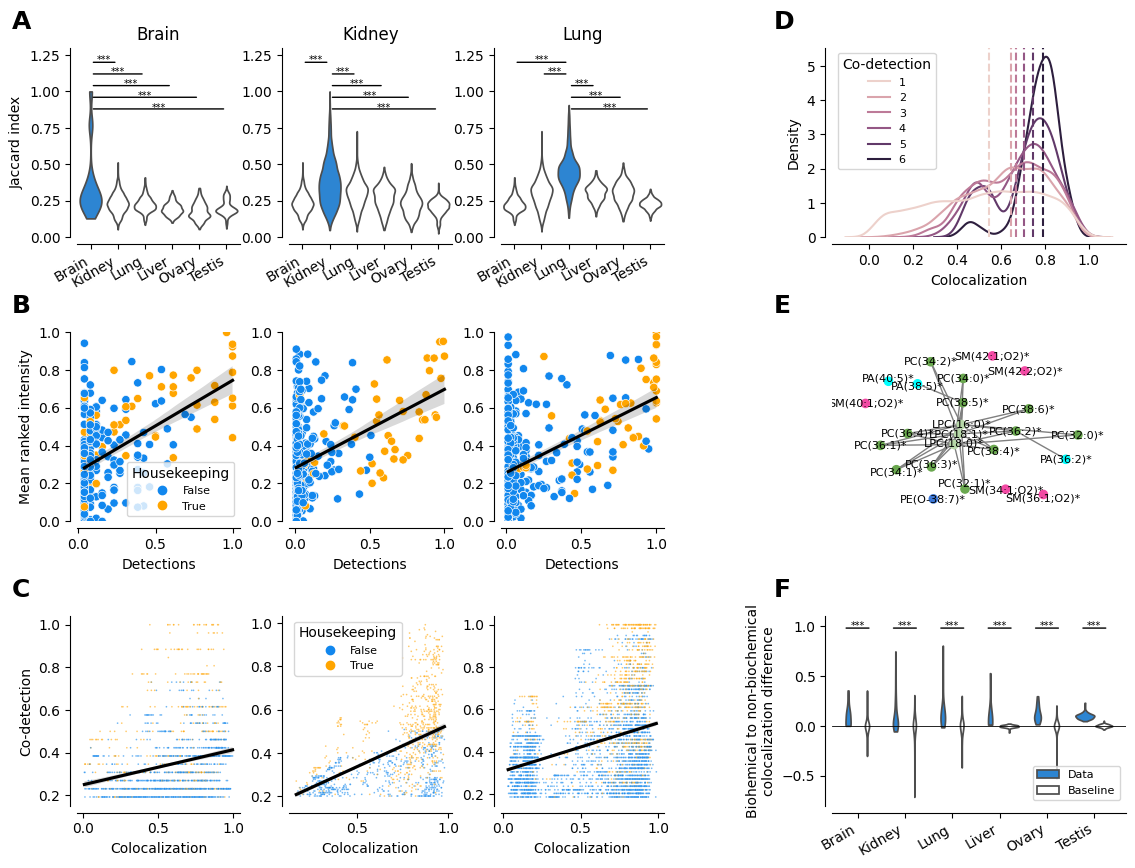

In [66]:
from matplotlib.lines import Line2D
# Old version, which included the brain molecular space
# fig = plt.figure(figsize=(30*cm, 40*cm))
# (subfig1, subfig2, subfig3) = fig.subfigures(3, 1, hspace=0.02, height_ratios=[3, 1.5, 2.])

fig = plt.figure(figsize=(30*cm, 25*cm))
subfig1 = fig.subfigures(1, 1, hspace=0.02)

(sub11, sub12) = subfig1.subfigures(1, 2, wspace=.08, width_ratios = (4, 2))

# Organ plots
axs0 = sub11.subplots(3, 3)
sub11.subplots_adjust(hspace=0.5, wspace=0.3)
    #left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4

# Inter organ coloc, Network & LINEX
axs1 = sub12.subplots(3, 1)


# ###########
# PLOTS
# ###########

# ----------
# Co-detection
# ----------

PLOT_ORDER = ['Brain', 'Kidney', 'Lung', 'Liver', 'Ovary', 'Epididymis']

# Brain
ax = axs0[0][0]
organ='Brain'
curr_dat = coid[coid['tissue1'] == organ]
sns.violinplot(data=curr_dat, x='hue', y='jaccard', palette=coid_pal, inner=None, ax=ax, cut=0, hue='hue', legend=False, order=[f'{organ}|{x}' for x in PLOT_ORDER])
sns.despine(offset=5, trim=False, ax=ax)
coid_axislabels(ax, first=True, organ=organ)
coid_test(coid, ax, organ)
replace_epididymis_axl(ax)
ax.text(-0.4, 1.1, 'A', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')

# Kidney
ax = axs0[0][1]
organ='Kidney'
curr_dat = coid[coid['tissue1'] == organ]
sns.violinplot(data=curr_dat, x='hue', y='jaccard', palette=coid_pal, inner=None, ax=ax, cut=0, hue='hue', legend=False, order=[f'{organ}|{x}' for x in PLOT_ORDER])
sns.despine(offset=5, trim=False, ax=ax)
coid_axislabels(ax, first=False, organ=organ)
coid_test(coid, ax, organ)
replace_epididymis_axl(ax)

# Lung
ax = axs0[0][2]
organ='Lung'
curr_dat = coid[coid['tissue1'] == organ]
sns.violinplot(data=curr_dat, x='hue', y='jaccard', palette=coid_pal, inner=None, ax=ax, cut=0, hue='hue', legend=False, order=[f'{organ}|{x}' for x in PLOT_ORDER])
sns.despine(offset=5, trim=False, ax=ax)
coid_axislabels(ax, first=False, organ=organ)
coid_test(coid, ax, organ)
replace_epididymis_axl(ax)

# ----------
# Detection - Intensity
# ----------

# Brain
ax = axs0[1][0]
organ='Brain'
curr_dat = pctl2[pctl2['Organ'] == organ]
detectionintensity_plot(curr_dat, ax, organ, first=True, legend=True)
leg = ax.legend()
handles, labels = ax.get_legend_handles_labels()
patches=[]
for handle, label in zip(handles, labels):
    patches.append(Line2D([], [], color=handle.get_color(), label=label, linewidth=.1, marker='o', linestyle=''))
legend = ax.legend(handles=patches, title='Housekeeping')
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.4, 1.1, 'B', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')

# Kidney
ax = axs0[1][1]
organ='Kidney'
curr_dat = pctl2[pctl2['Organ'] == organ]
detectionintensity_plot(curr_dat, ax, organ, first=False)
sns.despine(offset=5, trim=False, ax=ax)

# Lung
ax = axs0[1][2]
organ='Lung'
curr_dat = pctl2[pctl2['Organ'] == organ]
detectionintensity_plot(curr_dat, ax, organ, first=False)
sns.despine(offset=5, trim=False, ax=ax)

# ----------
# Co-detection - Coloc
# ----------

# Brain
ax = axs0[2][0]
organ='Brain'
curr_dat = df[df['tissue'] == organ]
coloccodetection_plot(curr_dat, organ, ax, first=True)
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.4, 1.1, 'C', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')

# Kidney
ax = axs0[2][1]
organ='Kidney'
curr_dat = df[df['tissue'] == organ]
coloccodetection_plot(curr_dat, organ, ax, legend=True)
sns.despine(offset=5, trim=False, ax=ax)
leg = ax.legend()
handles, labels = ax.get_legend_handles_labels()
patches=[]
for handle, label in zip(handles, labels):
    patches.append(Line2D([], [], color=handle.get_color(), label=label, linewidth=.1, marker='o', linestyle=''))
legend = ax.legend(handles=patches, title='Housekeeping')

# Lung
ax = axs0[2][2]
organ='Lung'
curr_dat = df[df['tissue'] == organ]
coloccodetection_plot(curr_dat, organ, ax)
sns.despine(offset=5, trim=False, ax=ax)

# ----------
# Inter organ co-detection
# ----------
ax=axs1[0]
interorgan_plot(coloccoid, ax)
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.2, 1.1, 'D', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')

# ----------
# Inter organ co-detection
# ----------
ax=axs1[1]
net_layout = draw_intertissuenetwork(ion_net, ax, k=.8)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
fac = .2
ax.set_xlim((xlim[0]-abs(fac*xlim[0]), xlim[1]+abs(fac*xlim[1])))
ax.set_ylim((ylim[0]-abs(fac*ylim[0]), ylim[1]+abs(fac*ylim[1])))
ax.text(-0.2, 1.1, 'E', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')

# ----------
# Biochemistry
# ----------
ax=axs1[2]
plot_biochemistry(ax, lxpv, lxpv_rand, order=PLOT_ORDER)
ax.text(-0.2, 1.1, 'F', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
replace_epididymis_axl(ax)

# ----------
# Brain moleculer space
# ----------

# axs2 = subfig2.subplots(1, 4)

# subfig2.subplots_adjust(left=0.0, right=1, wspace=.3, bottom=.2)
#     #left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4
# ax = axs2[0]
# sc.pl.umap(brain_adata, color='leiden', show=False, gene_symbols=None, ax=ax, size=30)
# ax.set_title('Brain lipid space')
# ax.legend(title='Leiden\ncluster', loc='lower right') # , bbox_to_anchor=(1, 1)
# ax.axis('off')

# plot_enrichment(test[0][test[0]['q.value_median'] <= sig_threshold], 0, max_elem, ax=axs2[1], axisfont=SMALLSMALL_SIZE, textfont=XXSMALL_SIZE)
# axs2[1].set_xlabel('Median enrichment score')
# plot_enrichment(test[1][test[1]['q.value_median'] <= sig_threshold], 1, max_elem, ax=axs2[2], axisfont=SMALLSMALL_SIZE, textfont=XXSMALL_SIZE)
# axs2[2].set_xlabel('Median enrichment score')
# plot_enrichment(test[4][test[4]['q.value_median'] <= sig_threshold], 4, max_elem, ax=axs2[3], axisfont=SMALLSMALL_SIZE, textfont=XXSMALL_SIZE)
# axs2[3].set_xlabel('Median enrichment score')



# # ----------
# # Brain cluster images
# # ----------
# #axs3 = subfig3.subplots(1)


# selection = ['2022-07-19_19h29m24s', '2017-02-17_14h41m43s', '2016-09-21_16h06m56s']
# cluster_assignment = brain_adata.obs.set_index('formula')['leiden']

# display_cluster_ion_images(cluster_assignment, tissue_ads[tissue], adata_selection=selection, q=60, fig=subfig3, transpose=[False, False, True])


plt.savefig('plots/casestudy3_1.pdf', bbox_inches='tight')

In [59]:
lxpv

,tissue,pval,bioch_coloc,other_coloc,-log10(p),significant,diff,type
0,Kidney,5.018198e-01,0.958954,0.947502,0.299452,False,0.011452,Data
1,Kidney,7.079089e-01,0.956492,0.941548,0.150023,False,0.014944,Data
2,Kidney,9.898879e-01,0.935712,0.921775,0.004414,False,0.013936,Data
3,Kidney,3.752463e-25,0.901395,0.471597,24.425684,True,0.429798,Data
4,Kidney,1.356194e-02,0.940418,0.921138,1.867678,True,0.019280,Data
...,...,...,...,...,...,...,...,...
292,Liver,4.059093e-43,0.825063,0.739798,42.391571,True,0.085265,Data
293,Liver,6.895768e-05,0.941575,0.871024,4.161417,True,0.070551,Data
294,Liver,7.770900e-36,0.902540,0.878419,35.109529,True,0.024121,Data
295,Liver,2.194076e-06,0.792095,0.772812,5.658748,True,0.019282,Data


In [64]:
# Saving for processing in main figure
pickle.dump(net_layout, open(os.path.join(figuredata_dir, 'net_layout.pickle'), "wb" ) )
pickle.dump(ion_net, open(os.path.join(figuredata_dir, 'net.pickle'), "wb" ) )
pickle.dump(lxpv, open(os.path.join(figuredata_dir, 'biochemistry.pickle'), "wb" ) )
pickle.dump(lxpv_rand, open(os.path.join(figuredata_dir, 'biochemistry_random.pickle'), "wb" ) )

# Additional Plot 1

In [40]:
tissue_colocs_neg = pickle.load(open(os.path.join(store_dir, 'neg_lip_tissue_colocs.pickle'), "rb" ))

ji = []
tissue1 = []
tissue2 = []

for tis1 in tissue_colocs_neg.keys():
    for tis2 in tissue_colocs_neg.keys():
        for dsid1, dsdf1 in tissue_colocs_neg[tis1]['coloc_dict'].items():
            for dsid2, dsdf2 in tissue_colocs_neg[tis2]['coloc_dict'].items():
                if dsid1 != dsid2:
                    ji.append(compute_dscoloc_jaccard(dsdf1, dsdf2))
                    tissue1.append(tis1)
                    tissue2.append(tis2)
coidneg = pd.DataFrame({'tissue1': tissue1, 'tissue2': tissue2, 'jaccard': ji})
coidneg['hue']=coidneg['tissue1'].str.cat(coidneg['tissue2'], sep='|')
                    
palneg = {}
for elem in set(coidneg['hue']):
    sp = elem.split('|')
    if sp[0] == sp[1]:
        palneg[elem] = '#1187ee'
    else:
        palneg[elem] = 'white'

/tmp/ipykernel_965/745354029.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=curr_dat, x='hue', y='jaccard', palette=palneg, inner=None, ax=ax, cut=0)
/tmp/ipykernel_965/745354029.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=curr_dat, x='hue', y='jaccard', palette=palneg, inner=None, ax=ax, cut=0)
/tmp/ipykernel_965/745354029.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=curr_dat, x='hue', y='jaccard', palette=palneg, inner=None, ax=ax, cut=0)
/tmp/ipykernel_965/745354029.py:68: FutureWarning: 

Pa

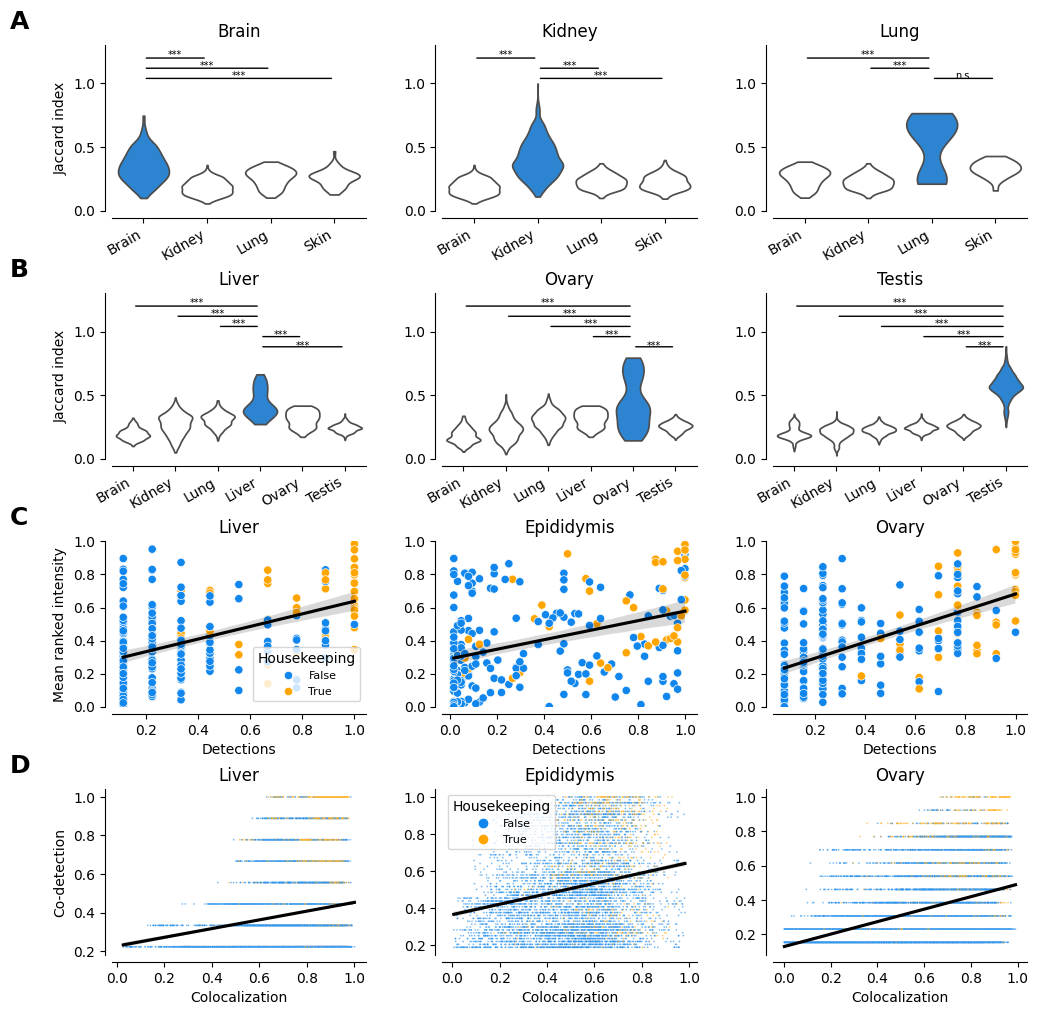

In [44]:
# fig = plt.figure(figsize=(30*cm, 40*cm))
# (subfig1, subfig2, subfig3) = fig.subfigures(3, 1, hspace=0.02, height_ratios=[3, 1.5, 2.])

fig = plt.figure(figsize=(30*cm, 30*cm))
(subfig2) = fig.subfigures(1, 1, hspace=0.0) # , height_ratios=[1.6, 4.]

# Organ plots
axs0 = subfig2.subplots(4, 3)
subfig2.subplots_adjust(hspace=0.5, wspace=0.3)
    #left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4


# ###########
# PLOTS
# ###########

# ----------
# Drawing
# ----------

#ax = subfig1.subplots(1)
#ax.imshow(image)
#ax.axis('off')
#ax.text(-0.2, 1.1, 'A', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')

# ----------
# Co-detection - Negative
# ----------

# Brain
ax = axs0[0][0]
organ='Brain'
curr_dat = coidneg[coidneg['tissue1'] == organ]
sns.violinplot(data=curr_dat, x='hue', y='jaccard', palette=palneg, inner=None, ax=ax, cut=0)
sns.despine(offset=5, trim=False, ax=ax)
coid_axislabels(ax, first=True, organ=organ)
coid_test(coidneg, ax, organ)
replace_epididymis_axl(ax)
ax.text(-0.4, 1.1, 'A', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')

# Kidney
ax = axs0[0][1]
organ='Kidney'
curr_dat = coidneg[coidneg['tissue1'] == organ]
sns.violinplot(data=curr_dat, x='hue', y='jaccard', palette=palneg, inner=None, ax=ax, cut=0)
sns.despine(offset=5, trim=False, ax=ax)
coid_axislabels(ax, first=False, organ=organ)
coid_test(coidneg, ax, organ)
replace_epididymis_axl(ax)

# Lung
ax = axs0[0][2]
organ='Lung'
curr_dat = coidneg[coidneg['tissue1'] == organ]
sns.violinplot(data=curr_dat, x='hue', y='jaccard', palette=palneg, inner=None, ax=ax, cut=0)
sns.despine(offset=5, trim=False, ax=ax)
coid_axislabels(ax, first=False, organ=organ)
coid_test(coidneg, ax, organ)
replace_epididymis_axl(ax)

# ----------
# Co-detection - Positive
# ----------

ax = axs0[1][0]
organ='Liver'
curr_dat = coid[coid['tissue1'] == organ]
sns.violinplot(data=curr_dat, x='hue', y='jaccard', palette=coid_pal, inner=None, ax=ax, cut=0, order=[f'{organ}|{x}' for x in PLOT_ORDER])
sns.despine(offset=5, trim=False, ax=ax)
coid_axislabels(ax, first=True, organ=organ)
coid_test(coid, ax, organ)
replace_epididymis_axl(ax)
ax.text(-0.4, 1.1, 'B', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')

ax = axs0[1][1]
organ='Ovary'
curr_dat = coid[coid['tissue1'] == organ]
sns.violinplot(data=curr_dat, x='hue', y='jaccard', palette=coid_pal, inner=None, ax=ax, cut=0, order=[f'{organ}|{x}' for x in PLOT_ORDER])
sns.despine(offset=5, trim=False, ax=ax)
coid_axislabels(ax, first=False, organ=organ)
coid_test(coid, ax, organ)
replace_epididymis_axl(ax)

ax = axs0[1][2]
organ='Epididymis'
curr_dat = coid[coid['tissue1'] == organ]
sns.violinplot(data=curr_dat, x='hue', y='jaccard', palette=coid_pal, inner=None, ax=ax, cut=0, order=[f'{organ}|{x}' for x in PLOT_ORDER])
sns.despine(offset=5, trim=False, ax=ax)
coid_axislabels(ax, first=False, organ=organ)
coid_test(coid, ax, organ)
replace_epididymis_axl(ax)
ax.set_title('Testis', fontsize=MEDIUM_SIZE)






# ----------
# Detection - Intensity
# ----------

# Brain
ax = axs0[2][0]
organ='Liver'
curr_dat = pctl2[pctl2['Organ'] == organ]
detectionintensity_plot(curr_dat, ax, organ, first=True, legend=True)
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.4, 1.1, 'C', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
ax.set_title(organ, fontsize=MEDIUM_SIZE)

# Kidney
ax = axs0[2][1]
organ='Epididymis'
curr_dat = pctl2[pctl2['Organ'] == organ]
detectionintensity_plot(curr_dat, ax, organ, first=False)
sns.despine(offset=5, trim=False, ax=ax)
ax.set_title(organ, fontsize=MEDIUM_SIZE)

# Lung
ax = axs0[2][2]
organ='Ovary'
curr_dat = pctl2[pctl2['Organ'] == organ]
detectionintensity_plot(curr_dat, ax, organ, first=False)
sns.despine(offset=5, trim=False, ax=ax)
ax.set_title(organ, fontsize=MEDIUM_SIZE)


# ----------
# Co-detection - Coloc
# ----------

# Brain
ax = axs0[3][0]
organ='Liver'
curr_dat = df[df['tissue'] == organ]
coloccodetection_plot(curr_dat, organ, ax, first=True)
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.4, 1.1, 'D', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
ax.set_title(organ, fontsize=MEDIUM_SIZE)

# Kidney
ax = axs0[3][1]
organ='Epididymis'
curr_dat = df[df['tissue'] == organ]
coloccodetection_plot(curr_dat, organ, ax, legend=True)
sns.despine(offset=5, trim=False, ax=ax)
ax.set_title(organ, fontsize=MEDIUM_SIZE)
leg = ax.legend()
handles, labels = ax.get_legend_handles_labels()
patches=[]
for handle, label in zip(handles, labels):
    patches.append(Line2D([], [], color=handle.get_color(), label=label, linewidth=.1, marker='o', linestyle=''))
legend = ax.legend(handles=patches, title='Housekeeping')

# Lung
ax = axs0[3][2]
organ='Ovary'
curr_dat = df[df['tissue'] == organ]
coloccodetection_plot(curr_dat, organ, ax)
sns.despine(offset=5, trim=False, ax=ax)
ax.set_title(organ, fontsize=MEDIUM_SIZE)
ax.set_title(organ, fontsize=MEDIUM_SIZE)

plt.show()

# Additional Plot 2

In [45]:
hmdb4_metclasses = pd.read_csv('database/HMDB_v4.csv')
hmdb4_metclasses = hmdb4_metclasses[['chemical_formula', 'super_class', 'class', 'sub_class']]

metaspace_annotation_super_class = {}
metaspace_annotation_class = {}
metaspace_annotation_sub_class = {}
for house in housekeeping.index:
    tmp = hmdb4_metclasses[hmdb4_metclasses['chemical_formula']==house]
    if tmp.shape[0] > 0:
        metaspace_annotation_super_class[house] = list(tmp['super_class'])
        metaspace_annotation_class[house] = list(tmp['class'])
        metaspace_annotation_sub_class[house] = list(tmp['sub_class'])
        
# Sample classes
def hmdb_sampling(housekeeping_dict, n=50):
    cd = defaultdict(float)
    
    for i in range(n):
        for molecule, classes in housekeeping_dict.items():
            cd[random.choice(classes)] += 1
            
    return pd.Series({key: val/n/len(housekeeping) for key, val in cd.items()}).reset_index().rename(columns={'index': 'class', 0: 'Mean fraction'})

In [48]:
sm = SMInstance()
ds = sm.dataset(id="2016-09-22_11h16m26s")
oi = ds.optical_images()

def ion_image(mol, adduct, ds, oi, ax, pol='+'):
    isotope_image = ds.isotope_images(mol, adduct)
    
    image = isotope_image._images[0]
    hotspot = np.percentile(image, 99)
    image[image > hotspot] = hotspot
    
    image = oi.ion_image_to_optical(image)
    image = np.array(image).sum(axis=2)
    
    ax.imshow(oi[0])
    ax.imshow(image, alpha=.6, cmap='viridis')
    ax.axis('off')
    
    ax.set_title(f'[{mol}{adduct}]{pol}')

/tmp/ipykernel_965/3952464439.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tks, rotation = 30, ha='right')
/tmp/ipykernel_965/3952464439.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tks, rotation = 30, ha='right')


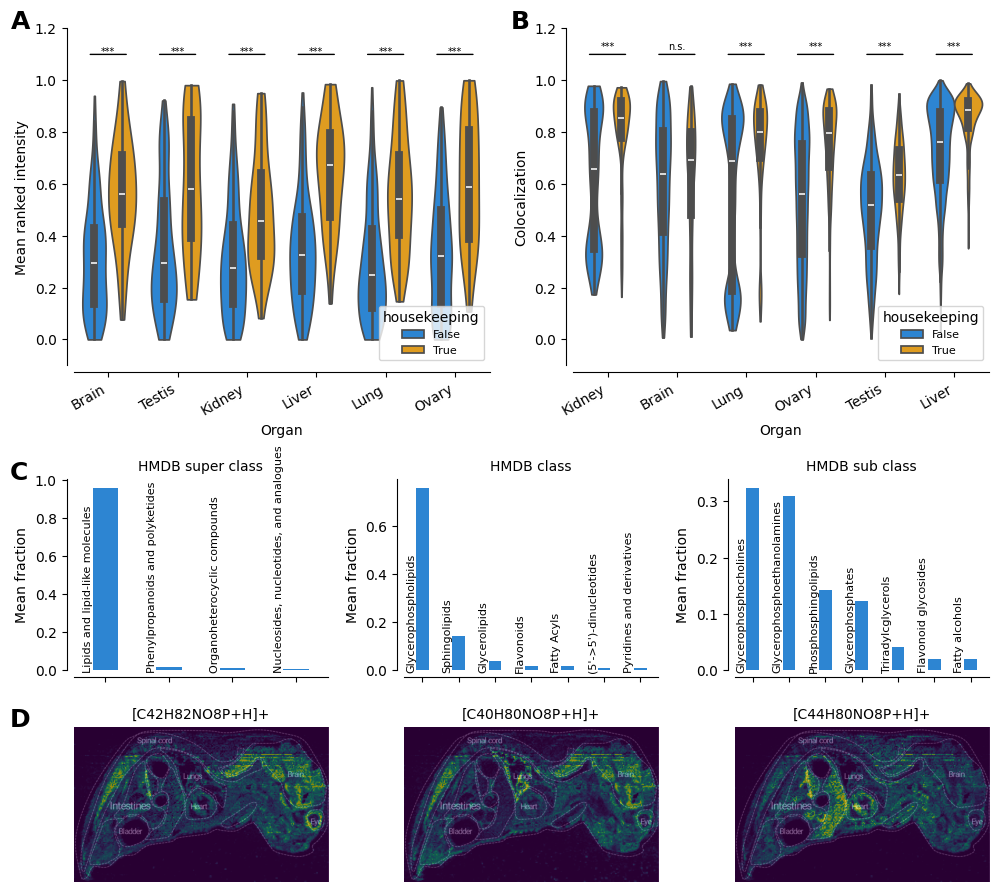

In [57]:
fig = plt.figure(figsize=(30*cm, 25*cm))
(subfig1, subfig2) = fig.subfigures(2, 1, height_ratios=[1.6, 2.])

axs1 = subfig1.subplots(1, 2)

axs2 = subfig2.subplots(2, 3)
subfig2.subplots_adjust(hspace=0.2, wspace=0.3)

# Household intensity
ax=axs1[0]
ax.text(-0.15, 1., 'A', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
sns.violinplot(data=pctl2, x='Organ', y='Mean ranked intensity', hue='housekeeping', palette={True: 'orange', False: '#1187ee'}, cut=0, ax=ax)
# Significance annotations
for pos, xtick in enumerate(ax.get_xticklabels()):
    tis_label = xtick.get_text()
    
    test_data = pctl2.loc[(pctl2['housekeeping'] == True) & (pctl2['Organ'] == tis_label), 'Mean ranked intensity']
    test_baseline = pctl2.loc[(pctl2['housekeeping'] == False) & (pctl2['Organ'] == tis_label), 'Mean ranked intensity']

    # P-value for difference with multiple testing correction
    testres = scipy.stats.mannwhitneyu(test_data, test_baseline).pvalue * len(ax.get_xticklabels())

    sigind = 'n.s.'
    sigind = '*' if testres <= 0.05 else sigind
    sigind = '**' if testres <= 0.01 else sigind
    sigind = '***' if testres <= 0.001 else sigind
    
    ax.annotate('', xy=(pos-.3, 1.1), xytext=(pos+.3,1.1), arrowprops=dict(arrowstyle='-', color='black'))
    ax.annotate(sigind, xy=(pos, 1.1), ha='center', fontsize=7)
ax.set_ylim((-.1, 1.2))
sns.move_legend(ax, "lower right")
sns.despine(offset=5, trim=False, ax=ax)
replace_epididymis_axl(ax)

# Coloc household
ax=axs1[1]
ax.text(-0.15, 1., 'B', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
sns.violinplot(data=df, x='tissue', y='mean', hue='housekeeping', palette={True: 'orange', False: '#1187ee'}, cut=0, ax=ax)
# Significance annotations
for pos, xtick in enumerate(ax.get_xticklabels()):
    tis_label = xtick.get_text()
    
    test_data = df.loc[(df['housekeeping'] == True) & (df['tissue'] == tis_label), 'mean']
    test_baseline = df.loc[(df['housekeeping'] == False) & (df['tissue'] == tis_label), 'mean']

    # P-value for difference with multiple testing correction
    testres = scipy.stats.mannwhitneyu(test_data, test_baseline).pvalue * len(ax.get_xticklabels())

    sigind = 'n.s.'
    sigind = '*' if testres <= 0.05 else sigind
    sigind = '**' if testres <= 0.01 else sigind
    sigind = '***' if testres <= 0.001 else sigind
    
    ax.annotate('', xy=(pos-.3, 1.1), xytext=(pos+.3,1.1), arrowprops=dict(arrowstyle='-', color='black'))
    ax.annotate(sigind, xy=(pos, 1.12), ha='center', fontsize=7)

ax.set_ylim((-.1, 1.2))
ax.set_xlabel('Organ')
ax.set_ylabel('Colocalization')
sns.move_legend(ax, "lower right")
sns.despine(offset=5, trim=False, ax=ax)
replace_epididymis_axl(ax)


# Household composition
ax=axs2[0][0]
ax.text(-0.25, 1., 'C', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
ont = metaspace_annotation_super_class
ont_name = 'HMDB super class'
ont2 = hmdb_sampling(ont).sort_values('Mean fraction', ascending=False)
sns.barplot(data=ont2, x='class', y='Mean fraction', color='#1187ee', ax=ax, width=.4)
ax.set_title(ont_name)
ax.set_xlabel('')
ax.set_xticklabels([], rotation = 30, ha='right')
counter=0
for ont in ont2['class']:
    ax.text(counter-.35, 0.00, ont, rotation=90, ha='left', size=SMALLSMALL_SIZE)
    counter += 1
sns.despine(offset=5, trim=False, ax=ax)

ax=axs2[0][1]
ont = metaspace_annotation_class
ont_name = 'HMDB class'
ont2 = hmdb_sampling(ont).sort_values('Mean fraction', ascending=False)
sns.barplot(data=ont2, x='class', y='Mean fraction', color='#1187ee', ax=ax, width=.35)
ax.set_title(ont_name)
ax.set_xlabel('')
ax.set_xticklabels([], rotation = 30, ha='right')
counter=0
for ont in ont2['class']:
    ax.text(counter-.45, 0.0, ont, rotation=90, ha='left', size=SMALLSMALL_SIZE)
    counter += 1
sns.despine(offset=5, trim=False, ax=ax)

ax=axs2[0][2]
ont = metaspace_annotation_sub_class
ont_name = 'HMDB sub class'
ont2 = hmdb_sampling(ont).sort_values('Mean fraction', ascending=False)
sns.barplot(data=ont2, x='class', y='Mean fraction', color='#1187ee', ax=ax, width=.35)
ax.set_title(ont_name)
ax.set_xlabel('')
ax.set_xticklabels([], rotation = 30, ha='right')
counter=0
for ont in ont2['class']:
    if ont is np.nan:
        pass
    else:
        ax.text(counter-.45, 0.0, ont, rotation=90, ha='left', size=SMALLSMALL_SIZE)
        counter += 1
sns.despine(offset=5, trim=False, ax=ax)


ions = [('C42H82NO8P', '+H'), ('C40H80NO8P', '+H'), ('C44H80NO8P', '+H')]

ion_image(ions[0][0], ions[0][1], ds, oi, ax=axs2[1][0])
ion_image(ions[1][0], ions[1][1], ds, oi, ax=axs2[1][1])
ion_image(ions[2][0], ions[2][1], ds, oi, ax=axs2[1][2])

axs2[1][0].text(-0.25, 1., 'D', transform=axs2[1][0].transAxes, size=BIGGER_SIZE, weight='bold')

plt.show()



# Additional Plot 3

In [50]:
df_neg = pd.concat([x['c_measures'].assign(tissue=tis) for tis, x in tissue_colocs_neg.items()])
df_neg['mean_sig'] = df_neg['pval_mean_corr'] <= 0.05
df_neg['mediqr_sig'] = df_neg['pval_mediqr_corr'] <= 0.05
c_concat_mean_neg = df_neg.drop(columns=['tissue', 'ion_pairs']).groupby(['ion_pairs']).agg(['mean', 'count', 'sum'])

coloccoid_neg = pd.DataFrame({'mean': c_concat_mean_neg[('mean', 'mean')],
                            'median': c_concat_mean_neg[('median', 'mean')],
                            'mediqr': c_concat_mean_neg[('mediqr', 'mean')],
                            'variance': c_concat_mean_neg[('variance', 'mean')], 
                            'cv': c_concat_mean_neg[('cv', 'mean')], 
                            'coocurrence': c_concat_mean_neg[('coocurrence', 'mean')],
                            'mean_sig': c_concat_mean_neg[('mean_sig', 'sum')],
                            'mediqr_sig': c_concat_mean_neg[('mediqr_sig', 'sum')],
                            'Co-detection in number of tissues': c_concat_mean_neg[('mean', 'count')]}

                            )

coloccoid_neg['In all datasets'] = coloccoid_neg['Co-detection in number of tissues']==len(set(df_neg['tissue']))

In [51]:
lxpv_pos = lxpv.copy()
lxpv_rand_pos = lxpv_rand.copy()

In [52]:
neg_lip_top_datasets = pickle.load(open(os.path.join(store_dir, 'neg_lip_top_datasets_list.pickle'), "rb" ))
tissue_ads_neg = load_alltissue_datasets(neg_lip_top_datasets)

# Calculate mass of every molecule
for tis, dsd in tissue_ads_neg.items():
    for dsid, ds in dsd.items():
        tissue_ads_neg[tis][dsid].var['mass'] = [Formula(x).mass for x in tissue_ads_neg[tis][dsid].var['formula'].values]

# Filter by mass
for tis, dsd in tissue_ads_neg.items():
    for dsid, ds in dsd.items():
        tmp = tissue_ads_neg[tis][dsid]
        tmp = tmp[:, tmp.var['mass'] <= 900]
        tissue_ads_neg[tis][dsid] = tmp[:, tmp.var['mass'] >= 400]

# Remove isobars
tissue_ads_neg = mark_isobars(tissue_ads_neg, ppm_threshold=3)
ll = []
for tis, dsd in tissue_ads_neg.items():
    for dsid, ds in dsd.items():
        if ds[:, ~ds.var['has_isobar']].shape[1] < 10:
            ll.append((tis, dsid))
        else:
            # Remove too big datasets
            if ds.shape[0] > 100000:
                ll.append((tis, dsid))
for item in ll:
    del tissue_ads_neg[item[0]][item[1]]
    
#tissue_colocs_neg = all_tissue_colocs_mp(tissue_adatas=tissue_ads_neg, min_dataset_fraction=0.2, shuffle=False, threads=3)

sampled_colocs_l_neg = [all_tissue_coloc_sampling_mp(tissue_colocs_neg, min_dataset_fraction=0.2, threads=3, save_coloc_dict=True) for i in range(10)]

tissue_lx = tissue_lx_nets_mp(tissue_colocs_neg, ref_lip_dict=ref_lip_dict, class_reacs=class_reacs, bootstraps=20, threads=3)

/tmp/ipykernel_2920/2241549867.py:7: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tissue_ads_neg[tis][dsid].var['mass'] = [Formula(x).mass for x in tissue_ads_neg[tis][dsid].var['formula'].values]
/tmp/ipykernel_2920/2241549867.py:7: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tissue_ads_neg[tis][dsid].var['mass'] = [Formula(x).mass for x in tissue_ads_neg[tis][dsid].var['formula'].values]
/tmp/ipykernel_2920/2241549867.py:7: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tissue_ads_neg[tis][dsid].var['mass'] = [Formula(x).mass for x in tissue_ads_neg[tis][dsid].var['formula'].values]
/tmp/ipykernel_2920/2241549867.py:7: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tissue_ads_neg[tis][dsid].var['mass'] = [Formula(x).mass for x in tissue_ads_neg[tis][dsid].var

Brain
Kidney
Lung
Kidney finished
Skin
Brain finished
Skin finished
Lung finished
Brain
Kidney
Lung
Kidney finished
Skin
Brain finished
Skin finished
Lung finished
Brain
Kidney
Lung
Kidney finished
Skin
Brain finished
Skin finished
Lung finished
Brain
Kidney
Lung
Kidney finished
Skin
Brain finished
Skin finished
Lung finished
Brain
Kidney
Lung
Kidney finished
Skin
Brain finished
Skin finished
Lung finished
Brain
Kidney
Lung
Kidney finished
Skin
Brain finished
Skin finished
Lung finished
Brain
Kidney
Lung
Kidney finished
Skin
Brain finished
Skin finished
Lung finished
Brain
Kidney
Lung


/home/trose/projects/metaspace_evaluation/coloc_utils.py:194: RuntimeWarning: invalid value encountered in double_scalars
  mediqr_l.append(med/iqr)


Kidney finished
Skin
Brain finished
Skin finished
Lung finished
Brain
Kidney
Lung
Kidney finished
Skin
Brain finished
Skin finished
Lung finished
Brain
Kidney
Lung
Kidney finished
Skin
Brain finished
Skin finished
Lung finished
Brain
Lung
Kidney
Lung done
Skin
Skin done
Brain done
Kidney done


In [53]:
tissue_l = []
pval_l = []
edge_med = []
nedge_med = []
for tissue in tissue_lx.keys():
    for dsid in tissue_lx[tissue]['nets'].keys():
        edge_cor = []
        nedge_cor = []
        eds_l = []
        nds_l = []

        max_hops = 2
        node_list = list(tissue_lx[tissue]['nets'][dsid].nodes)
        ig = tissue_lx[tissue]['nets'][dsid]
        ls = tissue_colocs_neg[tissue]['coloc_dict'][dsid]
        for l1 in range(len(node_list)):
            for l2 in range(l1+1, len(node_list)):
                if catch_sp(ig, node_list[l1], node_list[l2]) <= max_hops:
                    edge_cor.append(ls.loc[node_list[l1], node_list[l2]])
                    eds_l.append(dsid)
                else:
                    nedge_cor.append(ls.loc[node_list[l1], node_list[l2]])
                    nds_l.append(dsid)
        if len(edge_cor)>0 and len(nedge_cor)>0:
            testres = scipy.stats.ranksums(edge_cor, nedge_cor, alternative='two-sided')
            tissue_l.append(tissue)
            pval_l.append(testres.pvalue)
            edge_med.append(np.median(edge_cor))
            nedge_med.append(np.median(nedge_cor))

lxpv = pd.DataFrame({'tissue': tissue_l, 'pval': pval_l, 'bioch_coloc': edge_med, 'other_coloc': nedge_med})
lxpv['pval']= statsmodels.stats.multitest.multipletests(lxpv['pval'])[1]
mask = lxpv['pval'] > 1
lxpv.loc[mask, 'pval'] = 1
lxpv['-log10(p)'] = -np.log10(lxpv['pval'])

tissue_l = []
pval_l = []
edge_med = []
nedge_med = []
for samples in range(len(sampled_colocs_l_neg)):
    for tissue in tissue_lx.keys():
        for dsid in tissue_lx[tissue]['nets'].keys():
            edge_cor = []
            nedge_cor = []
            eds_l = []
            nds_l = []

            max_hops = 2
            node_list = list(tissue_lx[tissue]['nets'][dsid].nodes)
            ig = tissue_lx[tissue]['nets'][dsid]
            ls = sampled_colocs_l_neg[samples][tissue]['coloc_dict'][dsid]
            for l1 in range(len(node_list)):
                for l2 in range(l1+1, len(node_list)):
                    if catch_sp(ig, node_list[l1], node_list[l2]) <= max_hops:
                        edge_cor.append(ls.loc[node_list[l1], node_list[l2]])
                        eds_l.append(dsid)
                    else:
                        nedge_cor.append(ls.loc[node_list[l1], node_list[l2]])
                        nds_l.append(dsid)
            if len(edge_cor)>0 and len(nedge_cor)>0:
                testres = scipy.stats.ranksums(edge_cor, nedge_cor, alternative='two-sided')
                tissue_l.append(tissue)
                pval_l.append(testres.pvalue)
                edge_med.append(np.median(edge_cor))
                nedge_med.append(np.median(nedge_cor))

lxpv_rand = pd.DataFrame({'tissue': tissue_l, 'pval': pval_l, 'bioch_coloc': edge_med, 'other_coloc': nedge_med})

lxpv_rand['diff'] = lxpv_rand['bioch_coloc'] - lxpv_rand['other_coloc']

/tmp/ipykernel_2920/2644027399.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ticks, rotation = 30, ha='right')


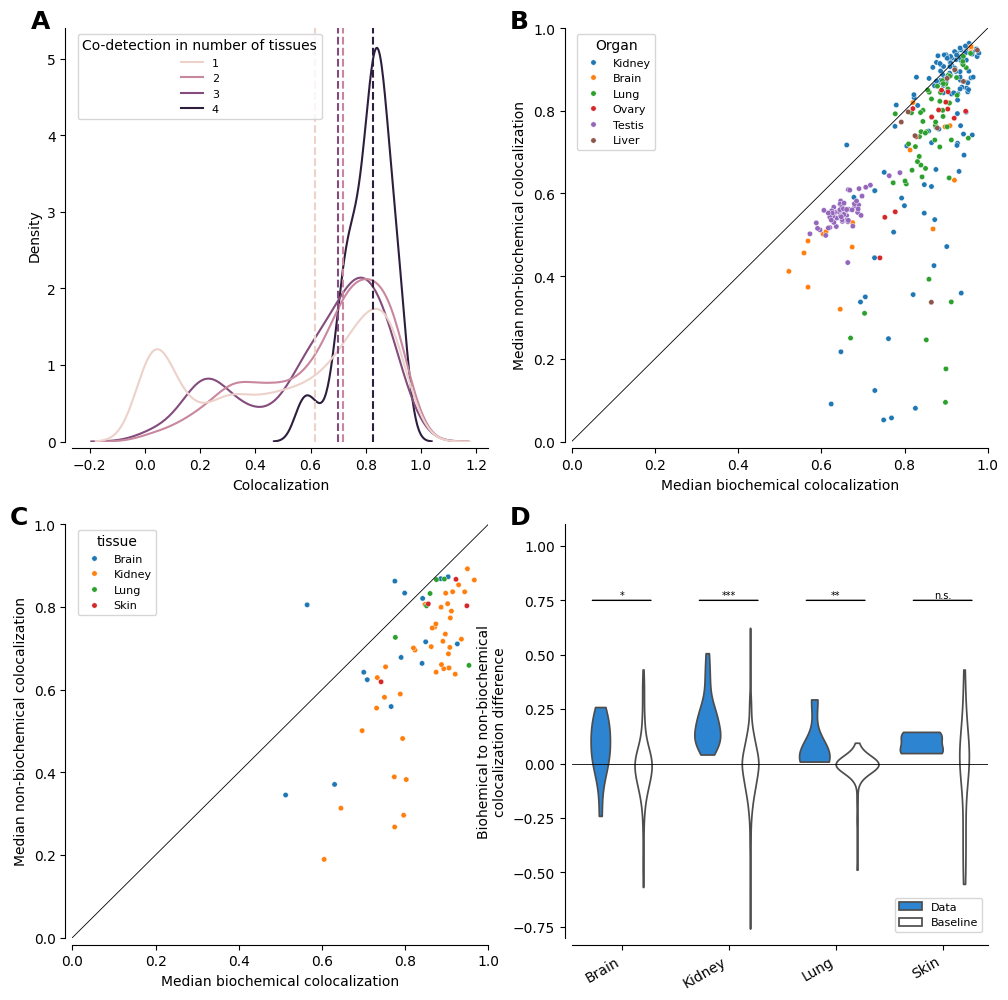

In [54]:
fig = plt.figure(figsize=(30*cm, 30*cm))
axs = fig.subplots(2,2)


ax = axs[0][0]
var = 'mean'
grouping = 'Co-detection in number of tissues'
sns.kdeplot(data=coloccoid_neg, x=var, hue=grouping, common_norm=False, ax=ax)
t = coloccoid_neg.groupby(grouping).agg('median')
colors = sns.cubehelix_palette(len(t))
counter=0
for k, v in t[var].items():
    # Add a vertical line at the median with the same hue color
    ax.axvline(x=v, color=colors[counter], linestyle="--")
    counter+=1
ax.set_xlabel('Colocalization')
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.1, 1., 'A', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')



ax = axs[0][1]
lxpv_pos['significant'] = lxpv_pos["-log10(p)"]>-np.log10(0.05)
lxpv_pos = lxpv_pos.rename(columns={'tissue':'Organ'})
lxpv_pos['Organ'] = lxpv_pos['Organ'].replace({'Epididymis': 'Testis'})
sns.scatterplot(data=lxpv_pos, x='bioch_coloc', y='other_coloc', hue='Organ', ax=ax, s=15)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.axline((0,0), (1,1), color='black', linestyle='-', linewidth=.6)
pctl = np.percentile(lxpv_rand_pos['diff'], [5, 95])
# ax.axline((0,0-pctl[0]), (1,1-pctl[0]), color='grey', linestyle='--', linewidth=.5)
# ax.axline((0,0-pctl[1]), (1,1-pctl[1]), color='grey', linestyle='--', linewidth=.5)
ax.set_xlabel('Median biochemical colocalization')
ax.set_ylabel('Median non-biochemical colocalization')
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.15, 1., 'B', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')

ax = axs[1][1]
plot_biochemistry(ax, lxpv, lxpv_rand, ly=.75, ty=.76)
ax.text(-0.15, 1., 'D', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')

ax = axs[1][0]
lxpv['significant'] = lxpv["-log10(p)"]>-np.log10(0.05)
lxpv['Organ'] = lxpv['tissue']
sns.scatterplot(data=lxpv, x='bioch_coloc', y='other_coloc', hue='tissue', ax=ax, s=15)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.axline((0,0), (1,1), color='black', linestyle='-', linewidth=.6)
pctl = np.percentile(lxpv_rand['diff'], [5, 95])
# ax.axline((0,0-pctl[0]), (1,1-pctl[0]), color='grey', linestyle='--', linewidth=.5)
# ax.axline((0,0-pctl[1]), (1,1-pctl[1]), color='grey', linestyle='--', linewidth=.5)
ax.set_xlabel('Median biochemical colocalization')
ax.set_ylabel('Median non-biochemical colocalization')
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.15, 1., 'C', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')




plt.show()